# **Table of Contents**
* [Data Wrangling](#section_21)<br><br>
* [Discovering Clusters](#section_2)
    * [Finding best 'K'](#section_3)
    * [Using best 'K'](#section_4)
    * [Cluster labelling](#section_5)
    * [Viewing Clusters](#section_6)<br><br>
* [Inference from Clusters](#section_7)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df  = pd.read_csv ("datasets/Backpain.csv")

df.sample(5)

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
64,76.147212,21.936186,82.961502,54.211027,123.932010,10.431972,Abnormal
300,50.676677,6.461501,35.000000,44.215175,116.587970,-0.214711,Normal
57,46.855781,15.351514,38.000000,31.504267,116.250917,1.662706,Abnormal
113,69.756665,19.279297,48.500000,50.477369,96.491370,51.169640,Abnormal
121,83.879941,23.077427,87.141512,60.802514,124.646072,80.555605,Abnormal


<a id='section_21'></a>
# **1 - Data Wrangling**

## **1.1 - Feature Selection via SelectKBest**

In [3]:
X  =  df.drop('class',axis=1)                                    
Y  =  df ['class']

In [4]:
from   sklearn.feature_selection   import   SelectKBest , f_classif

skb = SelectKBest ( f_classif , k=6 )                                             #  k = number of features

skb.fit_transform (X,Y)

skb.pvalues_

array([1.51633714e-10, 4.12267415e-09, 1.89844851e-08, 1.87695557e-04,
       2.52902204e-08, 2.20128631e-16])

> Comments
    
        * p-values of all features are less than 0.05 , hence all are significant predictors of Y
        * Lower the p-value , higher the significance , more the separation of clusters in graphs
        * From above , most significant feature is 'degree_spondylolisthesis'

## **1.2 - Drop**

* Dropping target column for clustering perspective.

In [5]:
df.drop ( 'class' , axis=1 , inplace =True )                    

## **1.3 - Transform**

In [6]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()

In [7]:
df = pd.DataFrame ( pt.fit_transform(df)  ,  columns = df.columns )

df.sample(5)

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
234,-1.466786,-0.786925,-0.451882,-1.132072,1.366653,-0.067024
168,1.787592,0.747197,1.988084,1.865081,-2.066408,1.003221
118,0.396346,0.685226,-0.224281,-0.030413,1.423056,0.022495
242,-1.353977,-1.220301,-1.529935,-0.663503,1.034138,-0.854259
99,-0.003082,-0.310376,-0.485061,0.210228,-0.206692,0.414747


<a id='section_2'></a>
# **2 - Discovering Clusters** 

<a id='section_3'></a>
## **2.1 - Finding Best K**

### **2.1.1 - Pairplot**

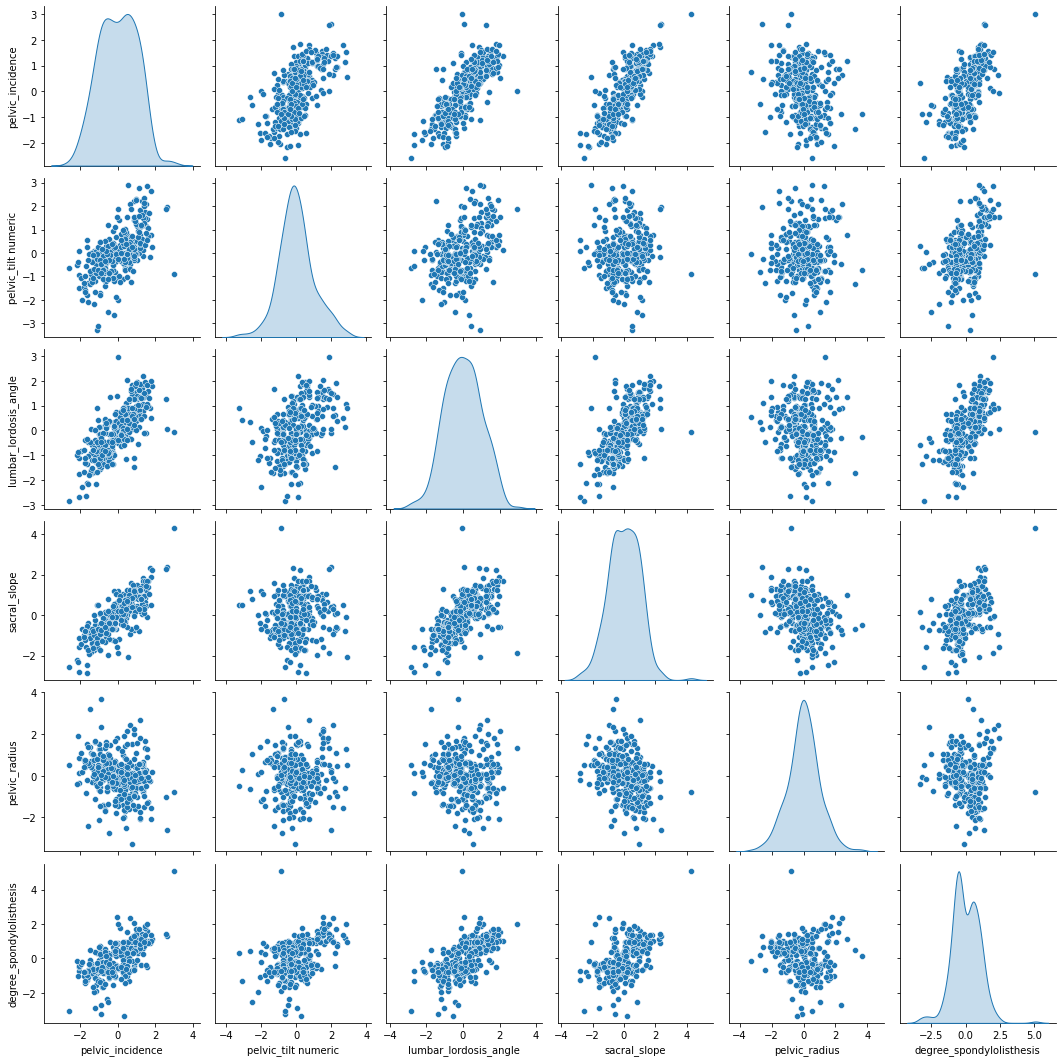

In [8]:
sns.pairplot ( df , diag_kind ='kde' ) ;

#### **Inference**
* Range of K = 2 to 6

### **2.1.2 - Elbow Plot**

In [9]:
from sklearn.cluster import KMeans

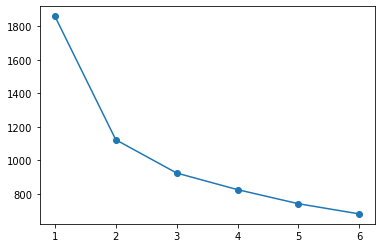

In [10]:
err    = []                      # wcss (within cluster sum square)     # inertia       # total spread

for k in range(1,7):
    
    KM  =  KMeans ( k , n_init =5 , max_iter =1000 , random_state =2 )
    KM.fit(df)            
    err.append    ( KM.inertia_  ) 
    
    
plt.plot  ( range(1,7)  , err  , marker='o') ;

### **2.1.3 - Silhouette Score**

In [11]:
from   sklearn.metrics   import  silhouette_score

In [12]:
scores =[]

for k in range(2,7):                                                               

    KM     =  KMeans (n_clusters =k , random_state =2)
    
    labels =  KM.fit_predict (df)

    avg    =  silhouette_score ( df , labels )
    
    scores.append ( {'k':k , 'Avg Silhouette Score':avg} )

In [13]:
table = pd.DataFrame (scores)

table.sort_values ( 'Avg Silhouette Score' , ascending=0 )  .head()    .style.hide_index()

k,Avg Silhouette Score
2,0.341496
3,0.268403
5,0.219377
4,0.207645
6,0.198661


### **2.1.4 - Dendrogram**

In [14]:
from sklearn.cluster          import  AgglomerativeClustering 
from scipy.cluster.hierarchy  import  dendrogram, linkage

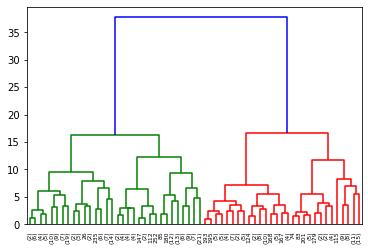

In [15]:
model  =  AgglomerativeClustering  (affinity ='euclidean' ,  linkage ='ward')

model.fit (df)

Z = linkage (df , 'ward')

dendrogram ( Z  ,  p=5  ,  truncate_mode='level')                                                  

plt.show()

<a id='section_4'></a>
## **2.2 - Using best K**

| Method | Best K |
| ---    | ---    |
| Elbow  | 2 |         
| Silhouette | 2 |
| Dendrogram | 2 |

In [16]:
KM    =  KMeans ( n_clusters=2 )  .fit (df)     

<a id='section_5'></a>
## **2.3 - Cluster labelling of records**

In [17]:
labels      =  KM.predict (df)                                        

df["cluster"] =  labels

<a id='section_6'></a>
## **2.4 - Viewing Clusters**

### **2.4.1 - Pairplot**

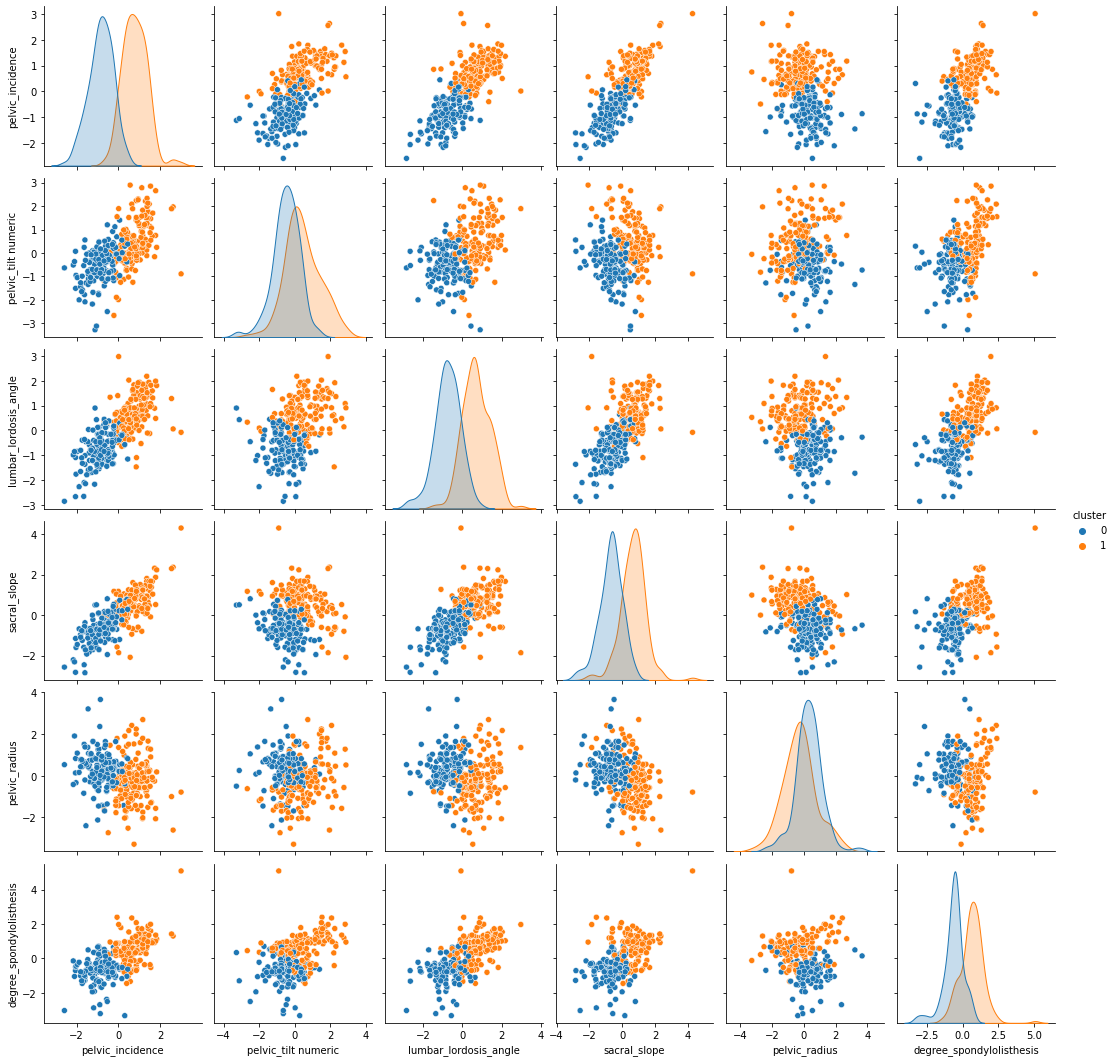

In [18]:
sns.pairplot ( df , diag_kind ='kde' , hue='cluster' ) ;

### **2.4.2 - Boxplot**

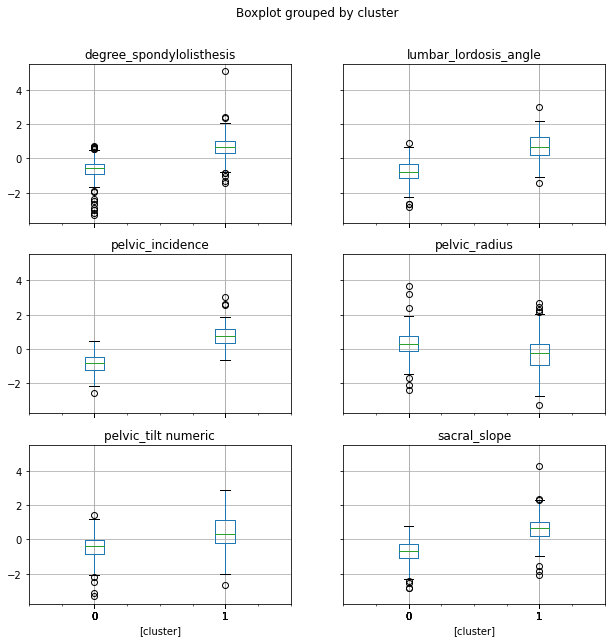

In [19]:
df.boxplot (by='cluster', figsize=(10,10))

plt.show()

### **2.4.3 Scatterplot**

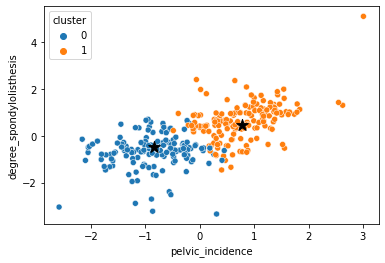

In [20]:
sns.scatterplot ( x='pelvic_incidence' ,  y='degree_spondylolisthesis'  ,  hue = 'cluster' , data=df )  

plt.scatter ( x = KM.cluster_centers_[:, 0] , y = KM.cluster_centers_[:, 1] , s=150 , c='black' , marker='*' )

plt.show()

<a id='section_7'></a>
# **3 - Inference from Clusters**

| Label | Signifies |
| ---    | ---    |
| 0  | Normal |         
| 1 | Abnormal |